In [11]:
import tqdm as tqdm
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from torch.nn.functional import relu
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from skimage import io
import torch
from skimage import color
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.init as init
from PIL import Image, ImageOps
import pickle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from torchvision.models.video import r3d_18


In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('y')
else:
    device = torch.device('cpu')
    print('n')


y


In [13]:
class AbdominalDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label = self.data_frame['target']

        self.transform = transform
    
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,
                                self.data_frame.iloc[idx, -2])

        image = np.load(img_name)
        label = self.label[idx]

        image = image.astype(np.float32)
        label = label.astype(np.float32)

        resized_image = F.interpolate(torch.tensor(image).unsqueeze(0).unsqueeze(0), size=(128, 128, 128), mode='trilinear', align_corners=False).squeeze().numpy()

        # Normalize the image
        min_image = np.min(resized_image)
        max_image = np.max(resized_image)
        resized_image = (resized_image - min_image) / (max_image - min_image + 1e-4)

        # Convert to tensors
        image = torch.tensor(resized_image).float().unsqueeze(0)
        label = torch.tensor(label).long()

        sample = {'x': image, 'y': label}

        if self.transform:
            sample = self.transform(sample)

        return sample



In [14]:
def train_model(model, dataloader, optimizer,  loss_fn, num_epochs = 10, verbose = False):
    acc_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()
            for data in dataloader[p]:
                optimizer.zero_grad()            
                image = data['x'].to(device)
                label = data['y'].to(device)
                output = model(image)
                loss = loss_fn(output, label)
                preds = torch.argmax(output, dim = 1)
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds ==label).item()
                running_loss += loss.item()*num_imgs
                running_total += num_imgs
                if p== 'train':
                    loss.backward()
                    optimizer.step()
                    
            epoch_acc = float(running_correct/running_total)
            epoch_loss = float(running_loss/running_total)
            if verbose or (i%10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format(p, epoch_loss, epoch_acc))

            acc_dict[p].append(epoch_acc)
            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    return model, acc_dict, loss_dict


In [15]:

bs = 2

torch.cuda.empty_cache()

current_directory = os.getcwd()
data_directory = os.path.join(current_directory, '..', 'data')

dataset = {'train': AbdominalDataset(os.path.join(data_directory, 'train_binary.csv'),'/vast/amr10211/deep_learning_final_project/masked_images/'), 
           'validate': AbdominalDataset(os.path.join(data_directory, 'val_binary.csv'),'/vast/amr10211/deep_learning_final_project/masked_images/'), 
           'test': AbdominalDataset(os.path.join(data_directory, 'test_binary.csv'),'/vast/amr10211/deep_learning_final_project/masked_images/')}
dataloader = {x: DataLoader(dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate']}

model = r3d_18(weights=True)
model.stem = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, 2)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

model, acc_dict, loss_dict = train_model(model, dataloader, optimizer, loss_fn=criterion, num_epochs = 10,  verbose=True)


/ext3/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0/9
----------
Phase:train, epoch loss: 0.3517 Acc: 0.8742
Phase:validate, epoch loss: 0.3562 Acc: 0.8787
Epoch: 1/9
----------
Phase:train, epoch loss: 0.3147 Acc: 0.9016
Phase:validate, epoch loss: 0.3302 Acc: 0.8809
Epoch: 2/9
----------
Phase:train, epoch loss: 0.3010 Acc: 0.9016
Phase:validate, epoch loss: 0.3535 Acc: 0.8766
Epoch: 3/9
----------
Phase:train, epoch loss: 0.2880 Acc: 0.9018
Phase:validate, epoch loss: 0.4156 Acc: 0.8553
Epoch: 4/9
----------
Phase:train, epoch loss: 0.2767 Acc: 0.9042
Phase:validate, epoch loss: 0.3456 Acc: 0.8830
Epoch: 5/9
----------
Phase:train, epoch loss: 0.2644 Acc: 0.9069
Phase:validate, epoch loss: 0.3218 Acc: 0.8809
Epoch: 6/9
----------
Phase:train, epoch loss: 0.2394 Acc: 0.9101
Phase:validate, epoch loss: 0.3414 Acc: 0.8766
Epoch: 7/9
----------
Phase:train, epoch loss: 0.2016 Acc: 0.9241
Phase:validate, epoch loss: 1.7656 Acc: 0.5000
Epoch: 8/9
----------
Phase:train, epoch loss: 0.1677 Acc: 0.9398
Phase:validate, epoch loss: 0.

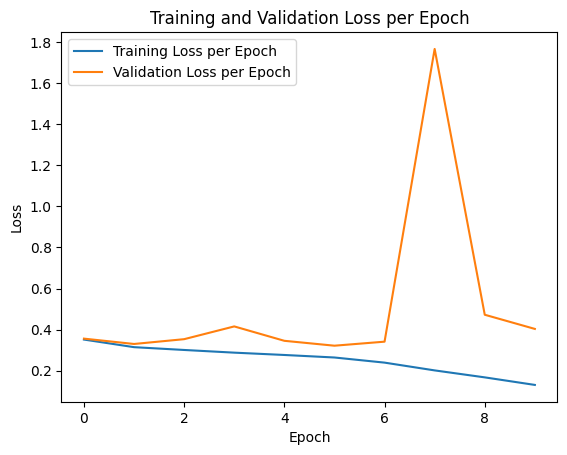

In [16]:
plt.plot(range(0,len(loss_dict['train'])),loss_dict['train'], label = 'Training Loss per Epoch')
plt.plot(range(0,len(loss_dict['validate'])),loss_dict['validate'],  label = 'Validation Loss per Epoch')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

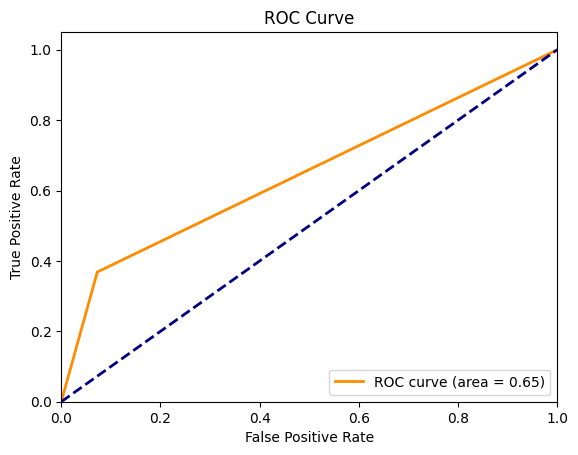

Validation Macro F1: 0.3888888888888889
Validation AUC: 0.6478909137249905


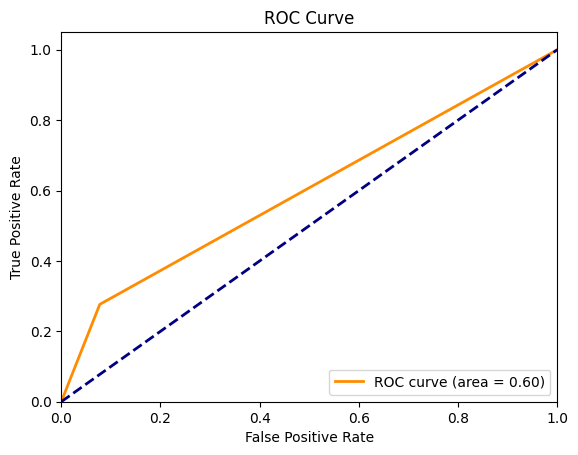

Test Macro F1: 0.27956989247311825
Test AUC: 0.5994743429286609


In [17]:
def evaluate_model(model, dataloader, device, num_classes):
    model.eval()
    total_samples = 0
    
    all_labels = np.array([])
    all_preds = np.array([])
    
    with torch.no_grad():
        for data in dataloader:
            image = data['x'].to(device)
            labels = data['y'].to(device)
            outputs = model(image)
            
            _, preds = torch.max(outputs, 1)
            
            all_labels = np.concatenate((all_labels, labels.cpu().numpy()), axis=0)
            all_preds = np.concatenate((all_preds, preds.cpu().numpy()), axis=0)
            
            total_samples += labels.size(0)
    
    # Calculate F1 score and AUC curve
    f1 = f1_score(all_labels, all_preds)
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    auc_score = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
        
    return f1, auc_score

eval_dataloader = {x: DataLoader(dataset[x], batch_size=bs,
                        shuffle=False, num_workers=0) for x in ['validate','test']}


val_f1, val_auc = evaluate_model(model, eval_dataloader['validate'], device, 2)
print("Validation Macro F1:", val_f1)
print("Validation AUC:", val_auc)

test_f1, test_auc = evaluate_model(model, eval_dataloader['test'], device, 2)
print("Test Macro F1:", test_f1)
print("Test AUC:", test_auc)

In [18]:
torch.save(model.state_dict(), 'classification_model_resnet18_cropped_binary_0-9.pth')

In [19]:
with open('loss_dict_resnet18_cropped_binary_0-9.pickle', 'wb') as handle:
    pickle.dump(loss_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
with open('acc_dict_resnet18_cropped_binary_0-9.pickle', 'wb') as handle:
    pickle.dump(acc_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)